In [15]:
!git clone https://github.com/ZIRA666/HST-Assignments.git

Cloning into 'HST-Assignments'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 51 (delta 10), reused 19 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 37.58 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [19]:
run /content/HST-Assignments/photometry_hst.py

SyntaxError: invalid syntax (photometry_hst.py, line 10)


----------------------------------------
HST PHOTOMETRY ASSIGNMENTS - NGC 1261

First Step : Combine images (cosmic ray removal with median)

Found 3 FITS files in data/F336W
Median-combined 3 images
Saved median image as text to: data/F336W/median_image.txt

Found 3 FITS files in data/F555W
Median-combined 3 images
Saved median image as text to: data/F555W/median_image.txt
Saved new files to f336w_combined.fits/.txt and f555w_combined.fits/.txt

Visualizing median(combined) images...
Save median images to median_combined_images.png


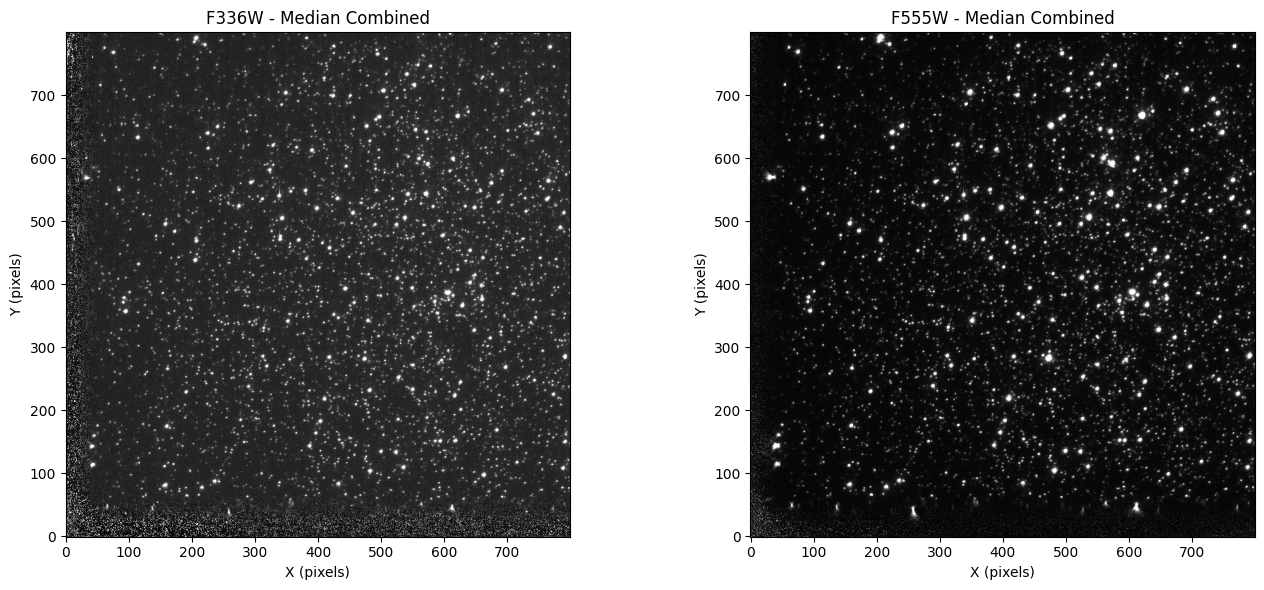


Second Step: Finding Star

----------------------------------------
FINDING STARS
Background: 0.67, Noise: 7.37, Threshold: 4.35
Found 5279 initial peaks (after filtering)


/tmp/ipython-input-4018763510.py:148: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian_2d, (xx, yy), cutout.ravel(),


  Processed 500 peaks...
  Processed 1000 peaks...
  Processed 1500 peaks...
  Processed 2000 peaks...
  Processed 2500 peaks...
  Processed 3000 peaks...
  Processed 3500 peaks...
  Processed 4000 peaks...
  Processed 4500 peaks...
  Processed 5000 peaks...
The catalog result: 2744 stars

----------------------------------------
FINDING STARS
Background: 1.22, Noise: 33.52, Threshold: 11.27
Found 3495 initial peaks (after filtering)
  Processed 500 peaks...
  Processed 1000 peaks...
  Processed 1500 peaks...
  Processed 2000 peaks...
  Processed 2500 peaks...
  Processed 3000 peaks...
The catalog result: 2572 stars

Detected stars: F336W - Detected Stars (show up to 3000)
Save to f336w_detected_stars.png


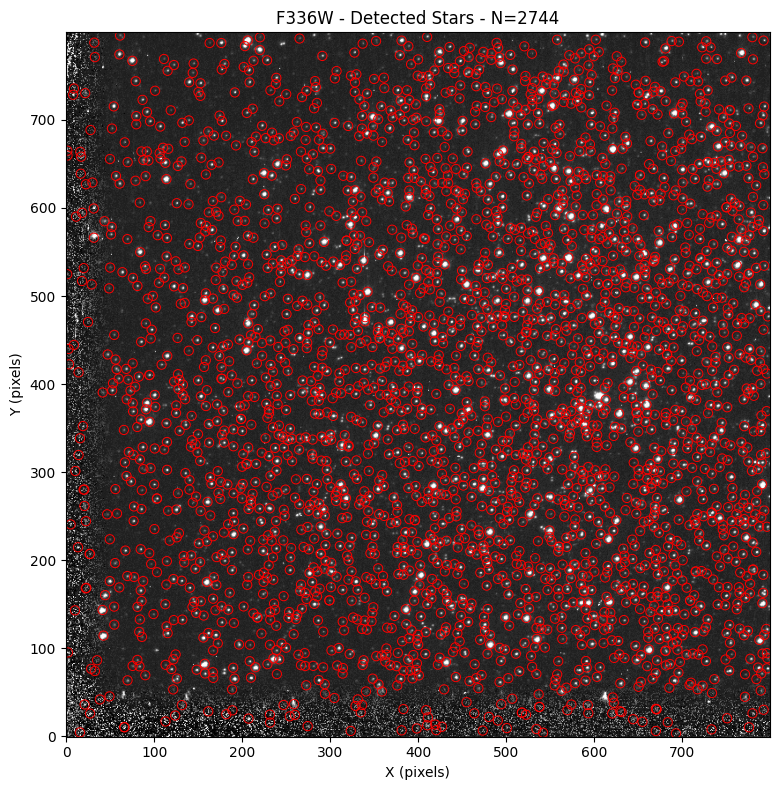


Detected stars: F555W - Detected Stars (show up to 3000)
Save to f555w_detected_stars.png


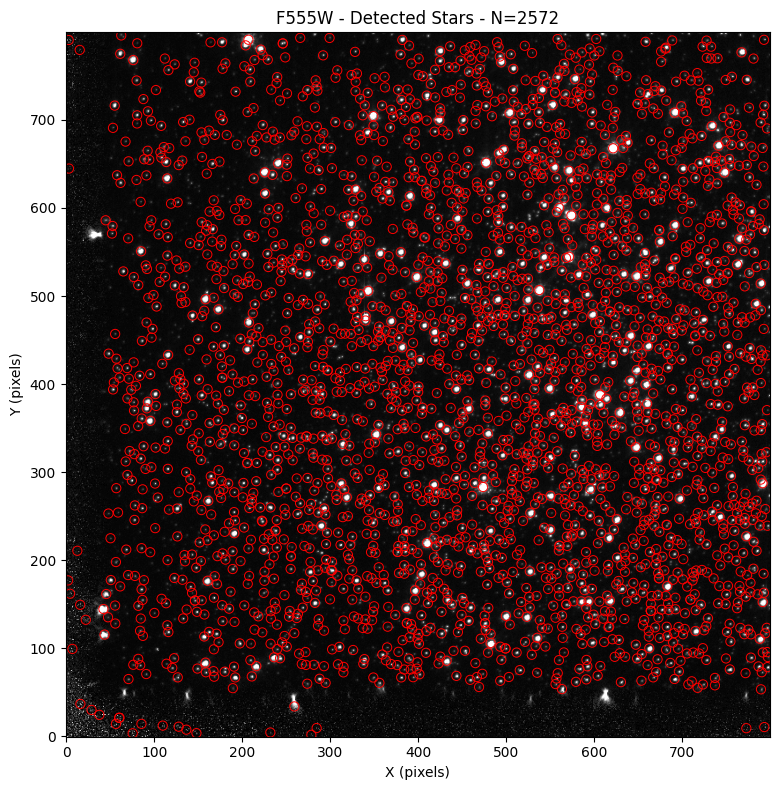


Third Step: Photometry

----------------------------------------
PHOTOMETRY
Aperture radius: 5 px
Sources after photometry: 2708 (out of 2744)

----------------------------------------
PHOTOMETRY
Aperture radius: 5 px
Sources after photometry: 2524 (out of 2572)

----------------------------------------
CROSS-MATCHING CATALOGS
Matched 2335 sources

Creating HR diagram...
HR diagram result: hr_diagram.png


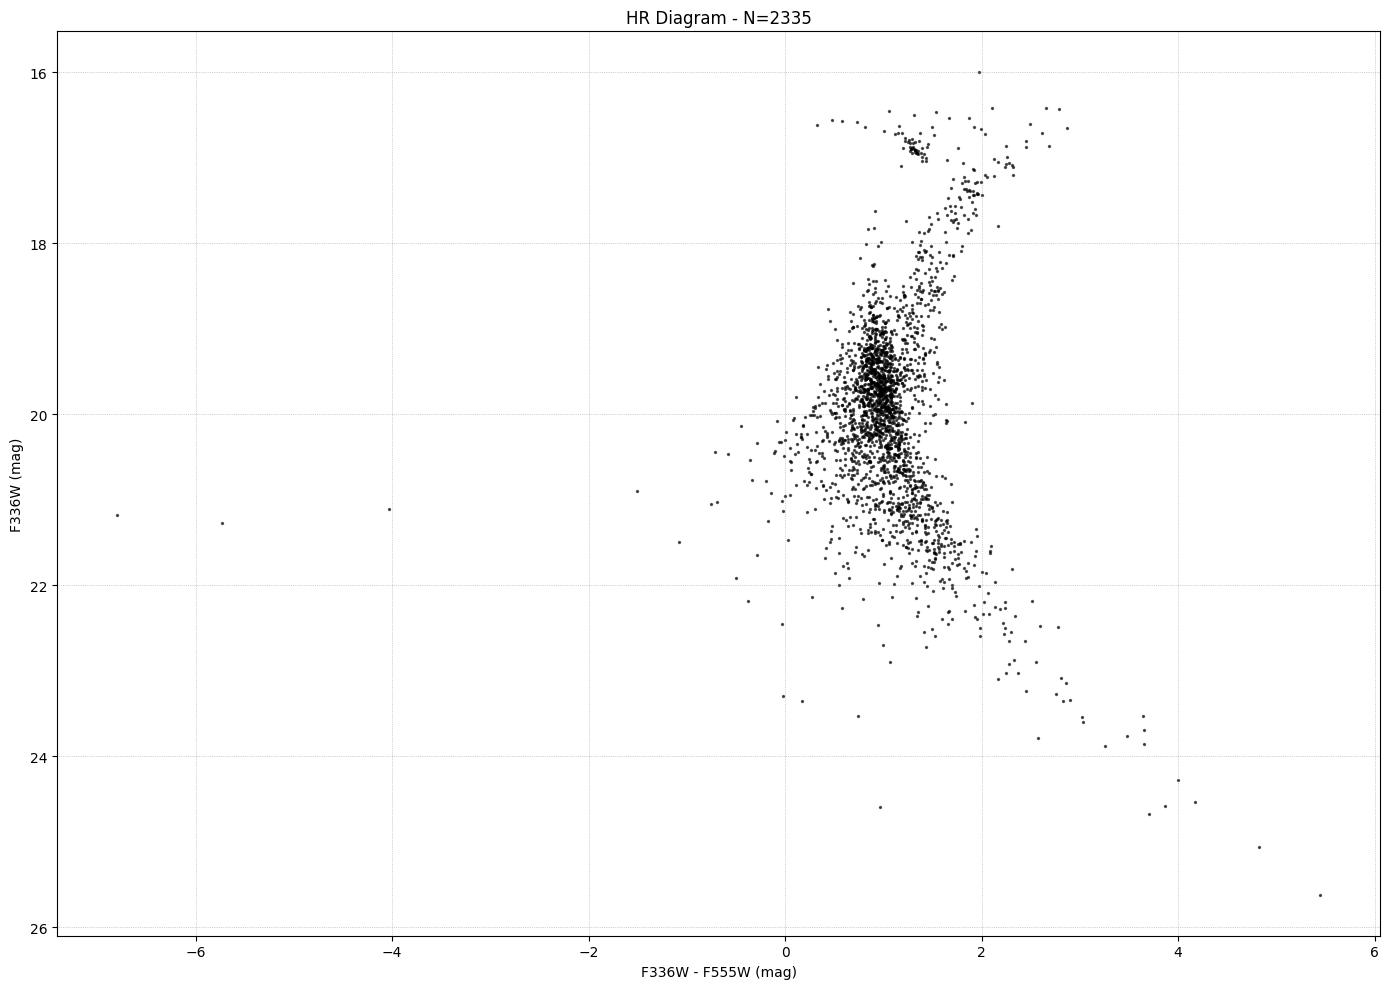


----------------------------------------
SUMMARY
Sources detected in F336W: 2708
Sources detected in F555W: 2524
Matched sources: 2335


In [20]:
#Import some modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter, maximum_filter
import glob
import os
from pathlib import Path

#get_ipython
# ----------------------------------------
# 1: COSMIC RAY REMOVAL
# ----------------------------------------

def load_and_combine_images(directory):
    """
    Load the FITS file directory and median-combine images (F336W and F555W).
    The result will save a text copy of the image "median_image.txt" in the directory.
    """
    directory = Path(directory)
    fits_files = sorted(glob.glob(str(directory / "*.fits")))

    if len(fits_files) == 0:
        raise ValueError(f"No FITS files found in {directory}")

    print(f"\nFound {len(fits_files)} FITS files in {directory}")

    images = []
    header = None

    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            # Find the HDU with data
            data = None
            for hdu in hdul:
                if hdu.data is not None:
                    data = hdu.data
                    if header is None:
                        header = hdu.header.copy()
                    break

            if data is not None:
                images.append(data)
            else:
                print(f"Warning: No data found in {fits_file.name}")

    if len(images) == 0:
        raise ValueError(f"No valid image data found in {directory}")

    #Median combine
    combinedimg = np.median(images, axis=0)
    print(f"Median-combined {len(images)} images")

    #Saving the text median image
    txtmd = directory / "median_image.txt"
    try:
        np.savetxt(txtmd, combinedimg, fmt="%.6e")
        print(f"Saved median image as text to: {txtmd}")
    except Exception as e:
        print(f"Could not save median text file: {e}")

    return combinedimg, header

# ----------------------------------------
# 2: FINDING THE STARS
# ----------------------------------------

def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, offset):
    x, y = xy
    g = offset + amplitude * np.exp(-(
        ((x - xo)**2 / (2 * sigma_x**2)) +
        ((y - yo)**2 / (2 * sigma_y**2))
    ))
    return g.ravel()

def find_local_maxima(image, box_size=5, threshold=None):
    """
    Find local maxima in an image using maximum filter.
    Based on workshop approach with better peak detection.
    """
    # Apply maximum filter to find local maxima
    local_max = maximum_filter(image, size=box_size)

    # Create boolean mask where image equals local maximum (peaks are True)
    local_max_mask = (image == local_max)

    # Apply brightness threshold if provided
    if threshold is not None:
        threshold_mask = (image > threshold)
        # Combine both conditions: must be local max AND above threshold
        local_max_mask = local_max_mask & threshold_mask

    # Get coordinates of all peaks
    coordinates = np.argwhere(local_max_mask)

    # Remove border peaks (within half box size of edges)
    # This ensures we can fit Gaussians without going off the image
    half = box_size // 2
    good_coords = []

    for y, x in coordinates:
        # Check if peak is not too close to image edges
        if (y >= half and x >= half and
            y < image.shape[0] - half and x < image.shape[1] - half):
            good_coords.append((y, x))

    # Convert to numpy array
    if len(good_coords) > 0:
        return np.array(good_coords)
    else:
        return np.array([])  # Return empty array if no peaks found

def check_ellips(sigma_x, sigma_y, etol=0.5):
    if sigma_x <= 0 or sigma_y <= 0:
        return False
    f = 1 - (min(sigma_x, sigma_y) / max(sigma_x, sigma_y))
    return f <= etol

def check_size(sigma_x, sigma_y, min_sigma=0.5, max_sigma=5.0):
    avg_sigma = (sigma_x + sigma_y) / 2
    return (min_sigma <= avg_sigma <= max_sigma)

def fit_source(image, y, x, box_size=9):
    half_box = box_size // 2
    y_min = max(0, y - half_box)
    y_max = min(image.shape[0], y + half_box + 1)
    x_min = max(0, x - half_box)
    x_max = min(image.shape[1], x + half_box + 1)

    cutout = image[y_min:y_max, x_min:x_max]
    if cutout.size == 0 or cutout.shape[0] < 5 or cutout.shape[1] < 5:
        return None

    yy, xx = np.mgrid[0:cutout.shape[0], 0:cutout.shape[1]]

    amplitude_guess = np.max(cutout) - np.median(cutout)
    amplitude_guess = max(amplitude_guess, 1.0)  # avoid zero initial amplitude
    xo_guess = cutout.shape[1] / 2
    yo_guess = cutout.shape[0] / 2
    sigma_guess = 2.0
    offset_guess = np.median(cutout)

    initial_guess = [amplitude_guess, xo_guess, yo_guess,
                     sigma_guess, sigma_guess, offset_guess]

    try:
        popt, _ = curve_fit(gaussian_2d, (xx, yy), cutout.ravel(),
                           p0=initial_guess, maxfev=2000)

        amplitude, xo, yo, sigma_x, sigma_y, offset = popt

        if amplitude <= 0:
            return None

        if offset < -1e3:  #unrealistic thing
            return None

        if not check_ellips(sigma_x, sigma_y):
            return None

        if not check_size(sigma_x, sigma_y):
            return None

        glob_x = x_min + xo
        glob_y = y_min + yo

        return {
            'x': float(glob_x),
            'y': float(glob_y),
            'amplitude': float(amplitude),
            'sigma_x': float(abs(sigma_x)),
            'sigma_y': float(abs(sigma_y)),
            'offset': float(offset)
        }

    except (RuntimeError, ValueError) as e:
        return None

def find_stars(image, sigma=0.5, threshold_factor=0.5, box_size=9):
    """
    Finding stars: smooth, threshold, local maxima, fit the Gaussian thing.
    Returns catalog (list of dicts).
    """
    print("\n" + "-"*40)
    print("FINDING STARS")

    smoothed = gaussian_filter(image, sigma=sigma)

    background = np.median(smoothed)
    noise = np.std(smoothed)
    threshold = background + threshold_factor * noise

    print(f"Background: {background:.2f}, Noise: {noise:.2f}, Threshold: {threshold:.2f}")

    maxima = find_local_maxima(smoothed, box_size=5, threshold=threshold)
    print(f"Found {len(maxima)} initial peaks (after filtering)")

    cat = []
    for i, (y, x) in enumerate(maxima):
        #progress print for large catalogs
        if i % 500 == 0 and i > 0:
            print(f"  Processed {i} peaks...")
        res = fit_source(image, int(y), int(x), box_size=box_size)
        if res is not None:
            res['id'] = len(cat) + 1
            cat.append(res)

    print(f"The catalog result: {len(cat)} stars")
    return cat

# ----------------------------------------
# 3: PHOTOMETRY
# ----------------------------------------

def aperture_photometry(image, x, y, aperture_radius=5,
                        sky_inner=8, sky_outer=12):
    """
    Do the circular aperture photometry
    """
    ny, nx = image.shape
    yy, xx = np.ogrid[:ny, :nx]
    r = np.sqrt((xx - x)**2 + (yy - y)**2)

    aperture_mask = r <= aperture_radius
    sky_mask = (r >= sky_inner) & (r <= sky_outer)

    if np.sum(aperture_mask) == 0:
        return 0.0

    if np.sum(sky_mask) > 0:
        sky_median = np.median(image[sky_mask])
    else:
        sky_median = 0.0

    aperture_flux = np.sum(image[aperture_mask])
    n_ap = np.sum(aperture_mask)
    sky_flux = sky_median * n_ap

    srcflux = aperture_flux - sky_flux
    return float(srcflux)

def flux_to_mag(flux, zeropoint=25.0):
    if flux > 0:
        return float(-2.5 * np.log10(flux) + zeropoint)
    else:
        return np.nan

def perform_photometry(image, catalog, aperture_radius=5):
    print("\n" + "-"*40)
    print("PHOTOMETRY")
    print(f"Aperture radius: {aperture_radius} px")

    for source in catalog:
        flux = aperture_photometry(image, source['x'], source['y'],
                                   aperture_radius=aperture_radius)
        source['flux'] = flux
        source['magnitude'] = flux_to_mag(flux)

    valid = [s for s in catalog if not np.isnan(s['magnitude'])]
    print(f"Sources after photometry: {len(valid)} (out of {len(catalog)})")
    return valid


# ----------------------------------------
# SECTION 4: CROSS-MATCH AND PLOT
# ----------------------------------------

def cross_match_cats(cat1, cat2, max_distance=2.0):
    print("\n" + "-"*40)
    print("CROSS-MATCHING CATALOGS")

    matched = []
    for s1 in cat1:
        best_match = None
        best_d = max_distance #d = distance
        for s2 in cat2:
            dist = np.hypot(s1['x'] - s2['x'], s1['y'] - s2['y'])
            if dist < best_d:
                best_d = dist
                best_match = s2
        if best_match is not None:
            matched.append({
                'id': len(matched) + 1,
                'x': (s1['x'] + best_match['x']) / 2.0,
                'y': (s1['y'] + best_match['y']) / 2.0,
                'mag_f336w': s1['magnitude'],
                'mag_f555w': best_match['magnitude'],
                'flux_f336w': s1['flux'],
                'flux_f555w': best_match['flux']
            })

    print(f"Matched {len(matched)} sources")
    return matched

def visualize_median(f336w_combined, f555w_combined,
                            output_file='median_images.png'):
    print("\nVisualizing median(combined) images...")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    vmin_336, vmax_336 = np.percentile(f336w_combined, [1, 99])
    axes[0].imshow(f336w_combined, cmap='gray', origin='lower', vmin=vmin_336, vmax=vmax_336)
    axes[0].set_title('F336W - Median Combined')

    vmin_555, vmax_555 = np.percentile(f555w_combined, [1, 99])
    axes[1].imshow(f555w_combined, cmap='gray', origin='lower', vmin=vmin_555, vmax=vmax_555)
    axes[1].set_title('F555W - Median Combined')

    for ax in axes:
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')

    plt.tight_layout()
    plt.savefig(output_file, dpi=200, bbox_inches='tight')
    print(f"Save median images to {output_file}")
    plt.show()
    return fig

def visualize_detected_stars(image, catalog, title='Detected Stars',
                             output_file='detected_stars.png', max_display=3000):
    print(f"\nDetected stars: {title} (show up to {max_display})")
    fig, ax = plt.subplots(figsize=(8, 8))
    vmin, vmax = np.percentile(image, [1, 99])
    ax.imshow(image, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    x_coords = [s['x'] for s in catalog[:max_display]]
    y_coords = [s['y'] for s in catalog[:max_display]]
    ax.scatter(x_coords, y_coords, s=44, facecolors='none', edgecolors='red', linewidths=0.7)
    ax.set_title(f"{title} - N={len(catalog)}")
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    plt.tight_layout()
    plt.savefig(output_file, dpi=200, bbox_inches='tight')
    print(f"Save to {output_file}")
    plt.show()
    return fig

def create_hr_diagram(matched_catalog, output_file='hr_diagram.png'):
    print("\nCreating HR diagram...")
    mag_f555w = np.array([s['mag_f555w'] for s in matched_catalog])
    mag_f336w = np.array([s['mag_f336w'] for s in matched_catalog])
    color = mag_f336w - mag_f555w

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.scatter(color, mag_f336w, s=2, color='k', alpha=0.6)
    ax.set_xlabel('F336W - F555W (mag)')
    ax.set_ylabel('F336W (mag)')
    ax.invert_yaxis()
    ax.grid(True, linestyle=':', linewidth=0.5, color='gray', alpha=0.7)
    plt.title(f'HR Diagram - N={len(matched_catalog)}')
    plt.tight_layout()
    plt.savefig(output_file, dpi=200, bbox_inches='tight')
    print(f"HR diagram result: {output_file}")
    plt.show()
    return fig

def save_cats(catalog, filename):
    filename = Path(filename)
    if len(catalog) == 0:
        print(f"No entries to save for {filename}")
        return

# ----------------------------------------
# MAIN THING
# ----------------------------------------
def main():
    print("\n" + "-"*40)
    print("HST PHOTOMETRY ASSIGNMENTS - NGC 1261")

    #directory
    f336w_dir = "data/F336W"
    f555w_dir = "data/F555W"

    for d in (f336w_dir, f555w_dir):
        if not os.path.isdir(d):
            print(f"Warning: directory does not exist: {d}")

    #1: combine + median
    print("\nFirst Step : Combine images (cosmic ray removal with median)")
    try:
        f336w_combined, f336w_header = load_and_combine_images(f336w_dir)
        f555w_combined, f555w_header = load_and_combine_images(f555w_dir)
    except Exception as e:
        print(f"Error while combining images: {e}")
        return

    #Save combined images as FITS & TXT in dir
    try:
        fits.writeto('f336w_combined.fits', f336w_combined, f336w_header, overwrite=True)
        fits.writeto('f555w_combined.fits', f555w_combined, f555w_header, overwrite=True)
        np.savetxt('f336w_combined.txt', f336w_combined, fmt="%.6e")
        np.savetxt('f555w_combined.txt', f555w_combined, fmt="%.6e")
        print("Saved new files to f336w_combined.fits/.txt and f555w_combined.fits/.txt")
    except Exception as e:
        print(f"Could not save combined files: {e}")

    #Visualize median(s)
    visualize_median(f336w_combined, f555w_combined, output_file='median_combined_images.png')

    #2: Finding Star
    print("\nSecond Step: Finding Star")
    cat_f336w = find_stars(f336w_combined, sigma=0.5, threshold_factor=0.5, box_size=9)
    cat_f555w = find_stars(f555w_combined, sigma=0.5, threshold_factor=0.3, box_size=9)

    #Show detected stars
    visualize_detected_stars(f336w_combined, cat_f336w, 'F336W - Detected Stars', 'f336w_detected_stars.png')
    visualize_detected_stars(f555w_combined, cat_f555w, 'F555W - Detected Stars', 'f555w_detected_stars.png')

    #3: Photometry
    print("\nThird Step: Photometry")
    cat_f336w = perform_photometry(f336w_combined, cat_f336w, aperture_radius=5)
    cat_f555w = perform_photometry(f555w_combined, cat_f555w, aperture_radius=5)

    #4: cross-match
    matched_catalog = cross_match_cats(cat_f336w, cat_f555w, max_distance=2.0)

    #Save catalogs
    save_cats(cat_f336w, 'catalog_f336w.txt')
    save_cats(cat_f555w, 'catalog_f555w.txt')
    save_cats(matched_catalog, 'catalog_matched.txt')

    #Plot HR diagram
    create_hr_diagram(matched_catalog, output_file='hr_diagram.png')

    #Summary
    print("\n" + "-"*40)
    print("SUMMARY")
    print(f"Sources detected in F336W: {len(cat_f336w)}")
    print(f"Sources detected in F555W: {len(cat_f555w)}")
    print(f"Matched sources: {len(matched_catalog)}")

if __name__ == "__main__":
    main()